In [132]:
%load_ext autoreload
%autoreload 2
import globals
import parse_data.prepare_data as prepare_data
import data_extraction.trial_list_filters as trial_list_filters
from matplotlib.patches import Wedge
from matplotlib import pyplot as plt
import data_extraction.get_indices as get_indices
import parse_data.identify_filepaths as identify_filepaths
import globals
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.patches import Polygon
from matplotlib import cm
import math
from parse_data import flip_rotate_trajectories
# import occupancy_and_strategy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import data_strings
import data_extraction.data_saving as data_saving
import plotting.plot_octagon as plot_octagon
import analysis.heatmap_phigh as heatmap_phigh
import pickle
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Adapted Benny's code into flexible functions


In [133]:
load_heatmap_data = True

In [134]:
if not load_heatmap_data:
    # load previously prepared data
    trial_lists_solo = data_saving.load_data(r'trial_lists_solo_combined_standard_50')
    trial_lists_social = data_saving.load_data(r'trial_lists_social_standard_50')
else:
    folder = "heatmap_phigh_variables"
    # variable_name = 'competitive_see-low_choose-high'
    variable_name = 'solo_see-low_choose-high'
     
    with open(os.path.join(folder, variable_name), 'rb') as f:
        bins_dict_wall_seen_wall_chosen, bins_dict_wall_seen = pickle.load(f)
    

In [135]:
trial_lists = trial_lists_social
num_players = 2
first_visible_wall_index = 1
chosen_wall_index = 0  # high wall

In [136]:
(trial_list_vis_filtered, trial_list_vis_and_choice_filtered) = heatmap_phigh.filter_pipeline_p_high_first_seen_wall(trial_lists,
                                                                                                        num_players,
                                                                                                        first_visible_wall_index,
                                                                                                        chosen_wall_index)

proportion loser's choice confident = 0.2549019607843137
proportion loser's choice confident = 0.2549019607843137
filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 0.]
And the number of valid trials at this step is 19
filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.
 0. 0.]
And the number of valid trials at this step is 27
proportion loser's choice confident = 0.5789473684210527
proportion loser's choice confident = 0.25925925925925924
proportion loser's choice confident = 0.189873417721519
proportion loser's choice confident = 0.18987341

In [137]:
# binning params
n_rows, n_cols = 10, 10
x_min, x_max = -20, 20
y_min, y_max = -20, 20
grid_width = (x_max - x_min) / n_cols
grid_height = (y_max - y_min) / n_rows

# initialise bin counts grid, choice grid
bins_dict_wall_seen = np.zeros((n_rows, n_cols))
bins_dict_wall_seen_wall_chosen = np.zeros((n_rows, n_cols))

# across player ID 1 or 2
for player_id in range(num_players):
    
    # filtered for trials where player saw specified first-seen wall
    trial_lists_denominator = trial_list_vis_filtered[player_id]
    # filter for trials where player additionally chose specified chosen wall
    trial_lists_numerator = trial_list_vis_and_choice_filtered[player_id]

    
    # across each trial list for this player ID
    for trial_list_index, trial_list in enumerate(trial_lists_denominator):

        # across each trial in the trial list
        for trial_index, trial in enumerate(trial_list):
            
            # get slice onset position (denominator)
            x_val, y_val = get_indices.get_player_slice_onset_loc(trial, player_id=player_id)

            # bin position
            x_bin = int((x_val - x_min) / grid_width)
            y_bin = int((y_val - y_min) / grid_height)

            # increment denominator bin count
            bins_dict_wall_seen[y_bin,x_bin] += 1



    # across each trial list for this player ID
    for trial_list_index, trial_list in enumerate(trial_lists_numerator):
        
        # across each trial in the filtered list
        for trial_index, trial in enumerate(trial_list):
            # get slice onset position (numerator)
            x_val, y_val = get_indices.get_player_slice_onset_loc(trial, player_id=player_id)

            # bin position
            x_bin = int((x_val - x_min) / grid_width)
            y_bin = int((y_val - y_min) / grid_height)

            # increment numerator bin count
            bins_dict_wall_seen_wall_chosen[y_bin,x_bin] += 1

    print(f"Done for player {player_id}, counts in numerator index (3,0): {bins_dict_wall_seen_wall_chosen[6,0]} ")

Done for player 0, counts in numerator index (3,0): 22.0 
Done for player 1, counts in numerator index (3,0): 31.0 


In [138]:
# bins_dict_wall_seen_wall_chosen, bins_dict_wall_seen

In [139]:
# element-wise division of numerator and denominator arrays, with handling for division by zero
pH_by_bin_low_social = np.divide(
    bins_dict_wall_seen_wall_chosen, bins_dict_wall_seen,
    out=np.zeros_like(bins_dict_wall_seen_wall_chosen, dtype=float),
    # boolean array to mask division for only non-zero denominator entries
    where=bins_dict_wall_seen > 0
)

# filter out bins with fewer than x trials
pH_by_bin_low_social[bins_dict_wall_seen <= 10] = np.nan

C:\Users\Tom\AppData\Local\Temp\ipykernel_13612\3873701531.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('inferno').copy()


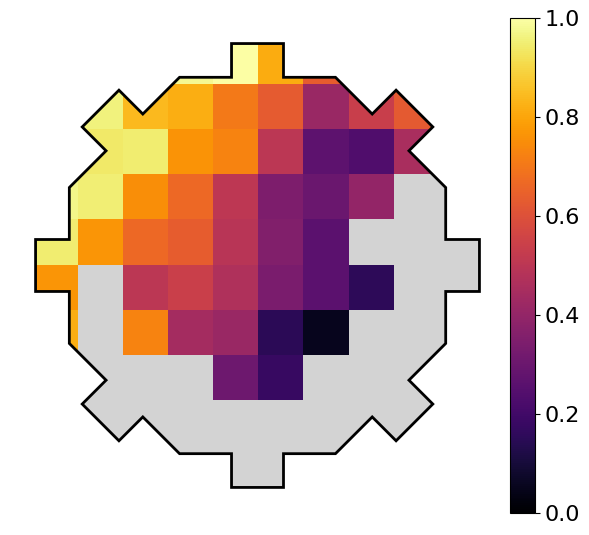

In [140]:

n_rows, n_cols = 10, 10
x_min, x_max = -20, 20
y_min, y_max = -20, 20
grid_width = (x_max - x_min) / n_cols
grid_height = (y_max - y_min) / n_rows

octagon_vertex_coordinates = plot_octagon.return_octagon_path_points()

fig, ax = plt.subplots(figsize=(6, 6))

cmap = cm.get_cmap('inferno').copy()
cmap.set_bad(color='lightgrey')
norm = mpl.colors.Normalize(vmin=0, vmax=1)

im = ax.imshow(pH_by_bin_low_social, extent=[x_min, x_max, y_min, y_max],
               origin='lower', norm=norm, cmap=cmap)

patch = Polygon(octagon_vertex_coordinates, edgecolor='black', facecolor='none', lw=2)
ax.add_patch(patch)
im.set_clip_path(patch)

ax.set_xlim([-22, 22])
ax.set_ylim([-22, 22])
ax.set_aspect(1.)
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
#cbar.set_label("Average Occupancy", fontsize=16)
cbar.ax.tick_params(labelsize=16)

plt.tight_layout()
plt.show()


In [131]:
# optionally save variables

folder = "heatmap_phigh_variables"
# variable_name = 'competitive_see-low_choose-high'
variable_name = 'competitive_see-high_choose-high'
path = os.path.join(folder, variable_name )
with open(path, 'wb') as f:
    pickle.dump((bins_dict_wall_seen_wall_chosen, bins_dict_wall_seen), f)